In [1]:
%matplotlib inline

# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pickle
from copy import deepcopy
from itertools import chain


# Import local paths
import sys, os
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs import Perception
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_grid

In [2]:
# Papermill notebook params
env = 'grid-20-v0'
trials = 1000
decay = False
biased_exploration=0

# Grid

Actions:

    MOVE_LEFT = 0
    MOVE_RIGHT = 1
    MOVE_UP = 2
    MOVE_DOWN = 3


In [3]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable() and cl.does_anticipate_change()])

# collect more metrics
def grid_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [4]:
cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        epsilon=0.95,
        biased_exploration=biased_exploration,
        beta=0.03,
        gamma=0.97,
        theta_i=0.1,
        theta_as=20,
        theta_exp=50,
        theta_ga=50,
        do_ga=True,
        mu=0.04,
        u_max=2,
        metrics_trial_frequency=10,
        user_metrics_collector_fcn=grid_metrics)

In [5]:
def print_cl(cl):
    arrows = ['⬅', '➡', '⬆', '⬇']
    action = arrows[cl.action]
    print(f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}], exp: {cl.exp}")

In [6]:
def print_simple_stats(population, metrics):
    pop_size = len(population)
    
    # avg step in trial
    steps = []
    for m in metrics:
        steps.append(m['steps_in_trial'])

    print(f"Population of {pop_size}, avg steps {sum(steps)/len(steps)}, all steps {sum(steps)}")     

In [7]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['population'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='macro')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

In [8]:
def plot_avg_fitness(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    avg_fitness = [m['avg_fitness'] for m in metrics]
    
    ax.plot(trials, avg_fitness, 'b')
    
    ax.set_title("Average fitness")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Fitness value")

## Grid

### Experiments

In [9]:
print(f'Running {trials} trials on [{env}], decay={decay}\n')
print(cfg)

Running 1000 trials on [grid-20-v0], decay=False

{'classifier_length': 2, 'number_of_possible_actions': 4, 'classifier_wildcard': '#', 'environment_adapter': <class 'lcs.agents.EnvironmentAdapter.EnvironmentAdapter'>, 'metrics_trial_frequency': 10, 'user_metrics_collector_fcn': <function grid_metrics at 0x111191048>, 'do_pee': False, 'fitness_fcn': None, 'do_ga': True, 'do_subsumption': True, 'do_action_planning': False, 'action_planning_frequency': 50, 'theta_exp': 50, 'beta': 0.03, 'gamma': 0.97, 'theta_i': 0.1, 'theta_r': 0.9, 'epsilon': 0.95, 'biased_exploration': 0, 'u_max': 2, 'theta_ga': 50, 'theta_as': 20, 'mu': 0.04, 'chi': 0.8}


In [10]:
grid = gym.make(env)

In [11]:
%%time
agent = ACS2(cfg)
population, metrics = agent.explore(grid, trials, decay=decay)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 979, 'reward': 1000, 'avg_fitness': nan, 'population': 97, 'numerosity': 380, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 1016, 'reward': 1000, 'avg_fitness': 201.89145193354693, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 988, 'reward': 1000, 'avg_fitness': 175.24749339357786, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 1175, 'reward': 1000, 'avg_fitness': 200.43549203277294, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agent

CPU times: user 10min 17s, sys: 3.59 s, total: 10min 21s
Wall time: 11min 1s


In [12]:
print_simple_stats(population, metrics)

Population of 80, avg steps 1188.44, all steps 118844


In [13]:
for cl in sorted(population, key=lambda cl: -cl.fitness):
    print_cl(cl)

#19 - ⬆ - #20 [fit: 189.561, r: 189.56, ir: 30.33], exp: 21231
18# - ➡ - 19# [fit: 170.596, r: 170.60, ir: 0.00], exp: 16910
19# - ➡ - 20# [fit: 169.011, r: 169.01, ir: 6.85], exp: 18870
20# - ⬅ - 19# [fit: 168.318, r: 168.32, ir: 0.00], exp: 18240
17# - ➡ - 18# [fit: 166.708, r: 166.71, ir: 0.00], exp: 14883
19# - ⬅ - 18# [fit: 166.595, r: 166.59, ir: 0.00], exp: 16301
#18 - ⬆ - #19 [fit: 165.466, r: 165.47, ir: 0.00], exp: 19027
#20 - ⬆ - ## [fit: 165.418, r: 165.42, ir: 0.00], exp: 17318
#19 - ⬇ - #18 [fit: 165.410, r: 165.41, ir: 0.00], exp: 18417
#17 - ⬆ - #18 [fit: 165.140, r: 165.14, ir: 0.00], exp: 16898
#20 - ⬇ - #19 [fit: 164.782, r: 164.78, ir: 0.00], exp: 20592
#16 - ⬆ - #17 [fit: 162.983, r: 162.98, ir: 0.00], exp: 14785
#18 - ⬇ - #17 [fit: 162.726, r: 162.73, ir: 0.00], exp: 16312
20# - ➡ - ## [fit: 161.484, r: 161.48, ir: 0.00], exp: 15232
18# - ⬅ - 17# [fit: 160.482, r: 160.48, ir: 0.00], exp: 14305
16# - ➡ - 17# [fit: 160.453, r: 160.45, ir: 0.00], exp: 13942
#17 - ⬇ -

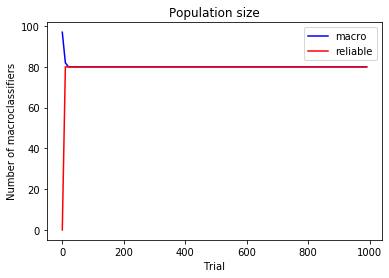

In [14]:
plot_population(metrics)

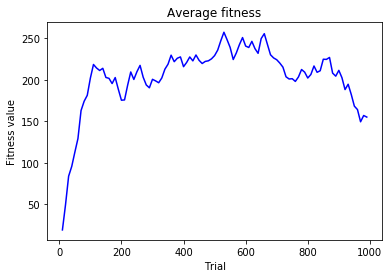

In [15]:
plot_avg_fitness(metrics)

### Pure exploitation

In [16]:
%%time
agent = ACS2(cfg, deepcopy(population))
pop_exploit, metric_exploit = agent.exploit(grid, 500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 153.4386079863838, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 249, 'reward': 1000, 'avg_fitness': 66.20150738181655, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 394, 'reward': 1000, 'avg_fitness': 26.81748584559781, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 10.668457463215757, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 6.1789631263819045, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'trial': 250, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 3.2913893609175124, 'population': 80, 'numerosity': 1600, 'reliable': 80}
INFO:lcs.agents.Agent:{'

CPU times: user 5min 14s, sys: 1.28 s, total: 5min 15s
Wall time: 5min 30s


In [17]:
print_simple_stats(pop_exploit, metric_exploit)

Population of 80, avg steps 1629.54, all steps 81477


In [18]:
for cl in sorted(pop_exploit, key=lambda cl: -cl.fitness):
    print_cl(cl)

#20 - ⬆ - ## [fit: 165.418, r: 165.42, ir: 0.00], exp: 17318
20# - ➡ - ## [fit: 161.484, r: 161.48, ir: 0.00], exp: 15232
#1 - ⬇ - ## [fit: 155.237, r: 155.24, ir: 0.00], exp: 14308
1# - ⬅ - ## [fit: 154.180, r: 154.18, ir: 0.00], exp: 16078
17# - ➡ - 18# [fit: 4.366, r: 4.37, ir: 0.00], exp: 14883
18# - ➡ - 19# [fit: 2.393, r: 2.39, ir: 0.00], exp: 16910
19# - ⬅ - 18# [fit: 2.322, r: 2.32, ir: 0.00], exp: 16301
16# - ➡ - 17# [fit: 0.725, r: 0.73, ir: 0.00], exp: 13942
15# - ➡ - 16# [fit: 0.338, r: 0.34, ir: 0.00], exp: 12920
19# - ➡ - 20# [fit: 0.324, r: 0.32, ir: 0.00], exp: 18870
20# - ⬅ - 19# [fit: 0.324, r: 0.32, ir: 0.00], exp: 18240
18# - ⬅ - 17# [fit: 0.324, r: 0.32, ir: 0.00], exp: 14305
17# - ⬅ - 16# [fit: 0.323, r: 0.32, ir: 0.00], exp: 13390
16# - ⬅ - 15# [fit: 0.322, r: 0.32, ir: 0.00], exp: 12401
15# - ⬅ - 14# [fit: 0.321, r: 0.32, ir: 0.00], exp: 11984
14# - ➡ - 15# [fit: 0.319, r: 0.32, ir: 0.00], exp: 12465
14# - ⬅ - 13# [fit: 0.319, r: 0.32, ir: 0.00], exp: 12253
13# 

### Manual tests

In [19]:
state = Perception(("5","10"))

match = pop_exploit.form_match_set(state)
for cl in sorted(match, key=lambda cl: -cl.fitness):
        if cl.does_anticipate_change():
            print_cl(cl)
#         else:
#             print_cl(cl)

#10 - ⬆ - #11 [fit: 0.313, r: 0.31, ir: 0.00], exp: 14211
#10 - ⬇ - #9 [fit: 0.313, r: 0.31, ir: 0.00], exp: 14164
5# - ⬅ - 4# [fit: 0.312, r: 0.31, ir: 0.00], exp: 16555
5# - ➡ - 6# [fit: 0.312, r: 0.31, ir: 0.00], exp: 16523


In [20]:
import random

def find_best_moves(population, state):
    def best_fitness(match_set, action):
        action_set = [cl for cl in match_set.form_action_set(action) if cl.does_anticipate_change()]
        random.shuffle(action_set)  # in case there are many actions available
        if len(action_set):
            best_cl = max(action_set, key=lambda cl: cl.fitness)
            return best_cl.fitness
        else:
            return 0  # if classifier predicts no change it's fitness is set to 0
    
    matching = population.form_match_set(state)
    
    return {
        "left": best_fitness(matching, 0),
        "right": best_fitness(matching, 1),
        "up": best_fitness(matching, 2),
        "down": best_fitness(matching, 3)
        
    }

find_best_moves(population, Perception(("1", "1")))

{'left': 0, 'right': 154.4237499431219, 'up': 153.89874010160074, 'down': 0}

In [21]:
dim = 20
step = 1. / dim

states = []

for x in range(0, dim):
    for y in range(0, dim):
        states.append({
            "pos": (x * step, y * step),
            "cord": (x+1, y+1),
            "best": find_best_moves(population, Perception((str(x+1), str(y+1))))
        })

# show first one
states[:1]

[{'pos': (0.0, 0.0),
  'cord': (1, 1),
  'best': {'left': 0,
   'right': 154.4237499431219,
   'up': 153.89874010160074,
   'down': 0}}]

In [22]:
fitness_values = list()
for s in states:
    for v in s['best'].values():
        if v is not None:
            fitness_values.append(v)

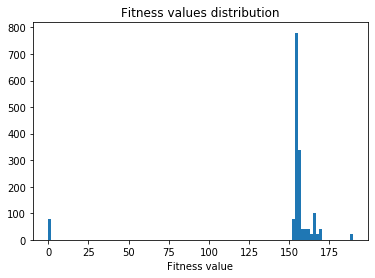

In [23]:
plt.hist(fitness_values, bins=100)
plt.title('Fitness values distribution')
plt.xlabel('Fitness value')
plt.show()

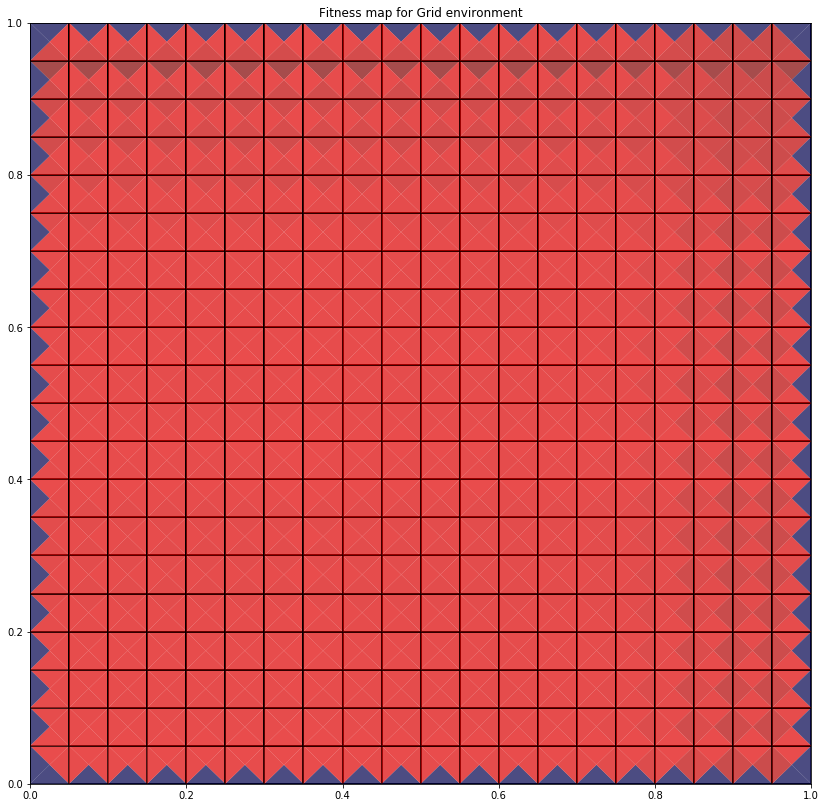

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx


cm = plt.get_cmap('seismic')
cNorm  = colors.Normalize(vmin=min(fitness_values), vmax=max(fitness_values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1, figsize=(14,14))

ax.set_title(f'Fitness map for Grid environment')
for state in states:
    (pos_x, pos_y) = state['pos']
    rect = patches.Rectangle((pos_x, pos_y), .2, .2, linewidth=2, edgecolor='black', facecolor='none', alpha=.7)
    
    alpha_triangles = 0.7
    
    down = plt.Polygon([(pos_x, pos_y), (pos_x+step, pos_y), (pos_x+step/2, pos_y+step/2)],
                       color=scalarMap.to_rgba(state['best']['down']),
                       alpha=alpha_triangles,linewidth=0)
    up = plt.Polygon([(pos_x, pos_y+step), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['up']),
                     alpha=alpha_triangles, linewidth=0)
    left = plt.Polygon([(pos_x, pos_y), (pos_x, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['left']),
                     alpha=alpha_triangles, linewidth=0)
    right = plt.Polygon([(pos_x+step, pos_y), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['right']),
                     alpha=alpha_triangles, linewidth=0)
    
#     plt.text(pos_x+step/2, pos_y+step/2, state['cord'], fontsize=11)  # cords
    
#     plt.text(pos_x+.07, pos_y+0.008,
#              round(state['best']['down'], 5),
#              fontsize=8)
#     plt.text(pos_x+.07, pos_y+0.18,
#              round(state['best']['up'], 5),
#              fontsize=8)
#     plt.text(pos_x+0.008, pos_y+0.07,
#              round(state['best']['left'], 5),
#              fontsize=8,
#              rotation=90)
#     plt.text(pos_x+0.17, pos_y+0.07,
#              round(state['best']['right'], 5),
#              fontsize=8,
#              rotation=-90)
    
    ax.add_patch(rect)
    ax.add_patch(down)
    ax.add_patch(up)
    ax.add_patch(left)
    ax.add_patch(right)

plt.show()

Save population and metrics

In [25]:
filename = f'{env}_{trials}_trials_decay_{decay}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics), f)